### 静的Newmark

In [3]:
import numpy as np
import scipy
from scipy.sparse.linalg import spsolve
from scipy.sparse import csr_matrix
import sys
import time
import matplotlib.pyplot as plt

In [4]:
def inputdata(fnameR, nod, nfree):  #データパス, 要素節点数, 自由度
    f = open(fnameR, 'r')
    text = f.readline()  # コメント
    text = f.readline()  # 1行ずつ読み込む
    text = text.strip()  # 端の空白, 改行(\n)を削除
    text = text.split()  # ','　で別れた要素ごとの配列にする
    npoin = int(text[0])  # ノード数
    nele = int(text[1])  # 要素数
    npfix = int(text[2])  # 拘束点数
    nlod = int(text[3])  # 荷重点数    
    # 配列宣言
    ae = np.zeros((11, nele), dtype=np.float64)  # 要素特性
    node = np.zeros((nod + 1, nele), dtype=np.int)  # 要素構成節点
    x = np.zeros((3, npoin), dtype=np.float64)  # 座標
    mpfix = np.zeros((nfree, npoin), dtype=np.int)  # 拘束状態
    rdis = np.zeros((nfree, npoin), dtype=np.float64)  # 既知変位
    fp = np.zeros(nfree * npoin, dtype=np.float64)  # 外力
    # 要素特性: ae
    text = f.readline()  # コメント
    for i in range(0, nele):
        text = f.readline()
        text = text.strip()
        text = text.split()
        ae[0, i] = float(text[0])  # E
        ae[1, i] = float(text[1])  # Po
        ae[2, i] = float(text[2])  # A
        ae[3, i] = float(text[3])  # Ix
        ae[4, i] = float(text[4])  # Iy
        ae[5, i] = float(text[5])  # Iz
        ae[6, i] = float(text[6])  # density
        ae[7, i] = float(text[7])  # gkx
        ae[8, i] = float(text[8])  # gky
        ae[9, i] = float(text[9])  # gkz

    text = f.readline()  # コメント
    # 要素構成節点: node
    for i in range(0, nele):
        text = f.readline()
        text = text.strip()
        text = text.split()
        node[0, i] = int(text[0])  #node_1
        node[1, i] = int(text[1])  #node_2
        node[2, i] = int(text[2])  #要素番号

    text = f.readline()  # コメント
    # 座標: x
    for i in range(0, npoin):
        text = f.readline()
        text = text.strip()
        text = text.split()
        x[0, i] = float(text[0])  # x-座標
        x[1, i] = float(text[1])  # y-座標
        x[2, i] = float(text[2])  # z-座標
    
    # 要素質量
    for i in range(0, nele):
        node1_x = x[0, i]
        #         node1_y = x[1, i]
        #         node1_z = x[2, i]
        node2_x = x[0, i + 1]
        #         node2_y = x[1, i+1]
        #         node2_z = x[2, i+1]
        A = ae[2, i]
        density = ae[6, i]
        ae[10, i] = abs(node1_x - node2_x) * A * density        

    text = f.readline()  # コメント
    # 境界条件（拘束状態） (0:free, 1:restricted)
    for i in range(0, npfix):
        text = f.readline()
        text = text.strip()
        text = text.split()
        lp = int(text[0])  # 固定されたノード番号
        mpfix[0, lp - 1] = int(text[1])  # x方向固定
        mpfix[1, lp - 1] = int(text[2])  # y方向固定
        mpfix[2, lp - 1] = int(text[3])  # z方向固定
        mpfix[3, lp - 1] = int(text[4])  # x軸回転固定
        mpfix[4, lp - 1] = int(text[5])  # y軸回転固定
        mpfix[5, lp - 1] = int(text[6])  # z軸回転固定
        rdis[0, lp - 1] = float(text[7])  # x方向既知変位
        rdis[1, lp - 1] = float(text[8])  # y方向既知変位
        rdis[2, lp - 1] = float(text[9])  # z方向既知変位
        rdis[3, lp - 1] = float(text[10])  # x軸既知回転量
        rdis[4, lp - 1] = float(text[11])  # y軸既知回転量
        rdis[5, lp - 1] = float(text[12])  # z軸既知回転量
            

    text = f.readline()  # コメント
    # 荷重
    for i in range(0, nlod):
        text = f.readline()
        text = text.strip()
        text = text.split()
        lp = int(text[0])
        fp[6 * lp - 6] = float(text[1])  # x方向荷重
        fp[6 * lp - 5] = float(text[2])  # y方向荷重
        fp[6 * lp - 4] = float(text[3])  # z方向荷重
        fp[6 * lp - 3] = float(text[4])  # x軸モーメント
        fp[6 * lp - 2] = float(text[5])  # y軸モーメント
        fp[6 * lp - 1] = float(text[6])  # z軸モーメント
            
    f.close()
    return npoin, nele, npfix, nlod, ae, node, x, mpfix, rdis, fp

In [5]:
# 要素剛性マトリックス作成（local）
def sm_3dfrm(EA,GJ,EIy,EIz,x1,y1,z1,x2,y2,z2):
    ek=np.zeros((12,12),dtype=np.float64) # local stiffness matrix
    xx=x2-x1
    yy=y2-y1
    zz=z2-z1
    el=np.sqrt(xx**2+yy**2+zz**2)
    ek[ 0, 0]= EA/el
    ek[ 0, 6]=-EA/el
    ek[ 1, 1]= 12*EIz/el**3
    ek[ 1, 5]=  6*EIz/el**2
    ek[ 1, 7]=-12*EIz/el**3
    ek[ 1,11]=  6*EIz/el**2
    ek[ 2, 2]= 12*EIy/el**3
    ek[ 2, 4]= -6*EIy/el**2
    ek[ 2, 8]=-12*EIy/el**3
    ek[ 2,10]= -6*EIy/el**2
    ek[ 3, 3]= GJ/el
    ek[ 3, 9]=-GJ/el
    ek[ 4, 2]= -6*EIy/el**2
    ek[ 4, 4]=  4*EIy/el
    ek[ 4, 8]=  6*EIy/el**2
    ek[ 4,10]=  2*EIy/el
    ek[ 5, 1]=  6*EIz/el**2
    ek[ 5, 5]=  4*EIz/el
    ek[ 5, 7]= -6*EIz/el**2
    ek[ 5,11]=  2*EIz/el
    ek[ 6, 0]=-EA/el
    ek[ 6, 6]= EA/el
    ek[ 7, 1]=-12*EIz/el**3
    ek[ 7, 5]= -6*EIz/el**2
    ek[ 7, 7]= 12*EIz/el**3
    ek[ 7,11]= -6*EIz/el**2
    ek[ 8, 2]=-12*EIy/el**3
    ek[ 8, 4]=  6*EIy/el**2
    ek[ 8, 8]= 12*EIy/el**3
    ek[ 8,10]=  6*EIy/el**2
    ek[ 9, 3]=-GJ/el
    ek[ 9, 9]= GJ/el
    ek[10, 2]= -6*EIy/el**2
    ek[10, 4]=  2*EIy/el
    ek[10, 8]=  6*EIy/el**2
    ek[10,10]=  4*EIy/el
    ek[11, 1]=  6*EIz/el**2
    ek[11, 5]=  2*EIz/el
    ek[11, 7]= -6*EIz/el**2
    ek[11,11]=  4*EIz/el
    return ek

In [6]:
def mass_3dfrm(ae_mass, npoin, nfree):
    # 番兵追加
    mass = np.append(ae_mass, 0.0)
    mass = np.insert(mass, 0, 0.0)
    ret = np.eye(npoin*nfree, dtype=np.float64)
    for i in range(0, len(mass) - 1):
        node_mass = (mass[i] + mass[i+1]) / 2.0
        for j in range(0, nfree):
            idx = i*nfree + j
            ret[idx,idx] *= node_mass
    return ret

In [7]:
def dumping_3dfrm(gamma, omega, mass_mat, gk):
    m = gamma * mass_mat
    gk = omega * gk    
    for i in range(0, len(gk)):
        gk[i, i] += m[i, i]        
    return gk

In [30]:
def main_3d_forward(file_path):
    start=time.time()
    args = sys.argv
    fnameR=args[1]
    fnameW=args[2]
    nod=2
    nfree=6
#     alpha=0.5 # newmark param
#     beta=0.25 # newmark param
#     gamma=0.01 # dumping param
#     omega=0.01 # dumping param
    npoin,nele,npfix,nlod, ae,node,x,mpfix,rdis,fp=inputdata(file_path ,nod,nfree)
    mass_mat=mass_3dfrm(ae[10], npoin, nfree)
    inv_mass_mat=np.linalg.inv(mass_mat)    
    dis=np.zeros(nfree*npoin, dtype=np.float64)
    ir=np.zeros(nod*nfree, dtype=np.int) 
    gk=np.zeros((nfree*npoin, nfree*npoin), dtype=np.float64) # Global stifness matrix
    # assembly stifness matrix & load vector
    for ne in range(0, nele):
        i=node[0,ne]-1
        j=node[1,ne]-1
        m=node[2,ne]-1
        x1=x[0,i]; y1=x[1,i]; z1=x[2,i]
        x2=x[0,j]; y2=x[1,j]; z2=x[2,j]
        ee   =ae[0,m]  # elastic modulus
        po   =ae[1,m]  # Poisson's ratio
        aa   =ae[2,m]  # section area
        aix  =ae[3,m]  # tortional constant
        aiy  =ae[4,m]  # moment of inertia around y-axis
        aiz  =ae[5,m]  # moment of inertia around z-axis
        den  =ae[6,m]  # unit density of material
        gkX  =ae[7,m]  # seismic coefficient in X-direction
        gkY  =ae[8,m]  # seismic coefficient in Y-direction
        gkZ  =ae[9,m]  # seismic coefficient in Z-direction
        A=aa  # section area
        EA=ee*aa
        GJ=ee/2/(1+po)*aix
        EIy=ee*aiy
        EIz=ee*aiz
        ek=sm_3dfrm(EA,GJ,EIy,EIz,x1,y1,z1,x2,y2,z2) # local stiffness matrix                                
        ir[11]=6*j+5; ir[10]=ir[11]-1; ir[9]=ir[10]-1; ir[8]=ir[9]-1; ir[7]=ir[8]-1; ir[6]=ir[7]-1
        ir[5] =6*i+5; ir[4] =ir[5]-1 ; ir[3]=ir[4]-1 ; ir[2]=ir[3]-1; ir[1]=ir[2]-1; ir[0]=ir[1]-1                
        # assemble
        for i in range(0, nod*nfree):
            it=ir[i]
            for j in range(0, nod*nfree):
                jt=ir[j]
                gk[it, jt] = gk[it, jt] + ek[i,j] 
       
    # boudary conditions
    for i in range(0, npoin):
        for j in range(0, nfree):
            if mpfix[j, i] == 1:                        
                iz=i*nfree+j
                fp[iz]=0.0

    for i in range (0, npoin):
        for j in range(0, nfree):
            if mpfix[j, i] == 1:
                iz=i*nfree+j
                gk[:,iz]=0.0
                gk[iz,iz]=1.0

    dis = np.linalg.solve(gk, fp)    
    # 拘束条件を再代入する
    for i in range(0, npoin):
        for j in range(0, nfree):
            if mpfix[j, i] == 1:
                iz=i*nfree+j
                dis[iz] = rdis[j, i]
    
    # z軸座標を計算
    z = np.zeros(23, dtype=np.float)
    for i in range(23):
        z[i] = dis[i * 6 + 2]
    # print out result
    dtime=time.time()-start
    print('time: {0:.3f}'.format(dtime)+'sec')
    return dis, z

In [31]:
file_path = 'test001.txt'
dis, z = main_3d_forward(file_path)

time: 0.009sec


#### 荷重を1 - 40へと増やした時の変位

In [27]:
# 荷重を引数にとるmain関数
def main_3d_forward_by_f(file_path, f):
    start=time.time()
    args = sys.argv
    fnameR=args[1]
    fnameW=args[2]
    nod=2
    nfree=6
    alpha=0.5 # newmark param
    beta=0.25 # newmark param
    gamma=0.01 # dumping param
    omega=0.01 # dumping param
    npoin,nele,npfix,nlod, ae,node,x,mpfix,rdis,fp=inputdata(file_path ,nod,nfree)
    fp[22 * 6 + 2] = f # 荷重変更
    mass_mat=mass_3dfrm(ae[10], npoin, nfree)
    inv_mass_mat=np.linalg.inv(mass_mat)    
    dis=np.zeros(nfree*npoin, dtype=np.float64)
    ir=np.zeros(nod*nfree, dtype=np.int) 
    gk=np.zeros((nfree*npoin, nfree*npoin), dtype=np.float64) # Global stifness matrix
    # assembly stifness matrix & load vector
    for ne in range(0, nele):
        i=node[0,ne]-1
        j=node[1,ne]-1
        m=node[2,ne]-1
        x1=x[0,i]; y1=x[1,i]; z1=x[2,i]
        x2=x[0,j]; y2=x[1,j]; z2=x[2,j]
        ee   =ae[0,m]  # elastic modulus
        po   =ae[1,m]  # Poisson's ratio
        aa   =ae[2,m]  # section area
        aix  =ae[3,m]  # tortional constant
        aiy  =ae[4,m]  # moment of inertia around y-axis
        aiz  =ae[5,m]  # moment of inertia around z-axis
        den  =ae[6,m]  # unit density of material
        gkX  =ae[7,m]  # seismic coefficient in X-direction
        gkY  =ae[8,m]  # seismic coefficient in Y-direction
        gkZ  =ae[9,m]  # seismic coefficient in Z-direction
        A=aa  # section area
        EA=ee*aa
        GJ=ee/2/(1+po)*aix
        EIy=ee*aiy
        EIz=ee*aiz
        ek=sm_3dfrm(EA,GJ,EIy,EIz,x1,y1,z1,x2,y2,z2) # local stiffness matrix                                
        ir[11]=6*j+5; ir[10]=ir[11]-1; ir[9]=ir[10]-1; ir[8]=ir[9]-1; ir[7]=ir[8]-1; ir[6]=ir[7]-1
        ir[5] =6*i+5; ir[4] =ir[5]-1 ; ir[3]=ir[4]-1 ; ir[2]=ir[3]-1; ir[1]=ir[2]-1; ir[0]=ir[1]-1                
        # assemble
        for i in range(0, nod*nfree):
            it=ir[i]
            for j in range(0, nod*nfree):
                jt=ir[j]
                gk[it, jt] = gk[it, jt] + ek[i,j] 
       
    # boudary conditions
    for i in range(0, npoin):
        for j in range(0, nfree):
            if mpfix[j, i] == 1:                        
                iz=i*nfree+j
                fp[iz]=0.0

    for i in range (0, npoin):
        for j in range(0, nfree):
            if mpfix[j, i] == 1:
                iz=i*nfree+j
                gk[:,iz]=0.0
                gk[iz,iz]=1.0

    dis = np.linalg.solve(gk, fp)    
    # 拘束条件を再代入する
    for i in range(0, npoin):
        for j in range(0, nfree):
            if mpfix[j, i] == 1:
                iz=i*nfree+j
                dis[iz] = rdis[j, i]
    
    # z軸座標を計算
    z = np.zeros(23, dtype=np.float)
    for i in range(23):
        z[i] = dis[i * 6 + 2]
    # print out result
    dtime=time.time()-start
    print('time: {0:.3f}'.format(dtime)+'sec')
    return dis, z

In [32]:
data = np.zeros((40, 23), dtype=np.float)
file_path = 'test001.txt'
for i in range(40):
    _, data[i] = main_3d_forward_by_f(file_path, i+1)

time: 0.009sec
time: 0.009sec
time: 0.011sec
time: 0.010sec
time: 0.008sec
time: 0.008sec
time: 0.009sec
time: 0.008sec
time: 0.007sec
time: 0.007sec
time: 0.007sec
time: 0.007sec
time: 0.007sec
time: 0.006sec
time: 0.006sec
time: 0.006sec
time: 0.006sec
time: 0.006sec
time: 0.007sec
time: 0.007sec
time: 0.007sec
time: 0.006sec
time: 0.006sec
time: 0.006sec
time: 0.007sec
time: 0.007sec
time: 0.007sec
time: 0.006sec
time: 0.007sec
time: 0.006sec
time: 0.007sec
time: 0.007sec
time: 0.007sec
time: 0.007sec
time: 0.007sec
time: 0.007sec
time: 0.012sec
time: 0.009sec
time: 0.008sec
time: 0.007sec


In [37]:
# データを保存
import pickle
with open('静的荷重z方向変位データ001', 'wb') as f:
    pickle.dump(data, f)

In [38]:
# データ読み込み
with open('静的荷重z方向変位データ001', 'rb') as f:
    data001 = pickle.load(f)

In [41]:
zs = np.zeros(len(data001), dtype=np.float64)
for i in range(len(zs)):
    zs[i] = data001[i, 22]

array([0.00515243, 0.01030486, 0.01545729, 0.02060972, 0.02576215,
       0.03091458, 0.036067  , 0.04121943, 0.04637186, 0.05152429,
       0.05667672, 0.06182915, 0.06698158, 0.07213401, 0.07728644,
       0.08243887, 0.0875913 , 0.09274373, 0.09789615, 0.10304858,
       0.10820101, 0.11335344, 0.11850587, 0.1236583 , 0.12881073,
       0.13396316, 0.13911559, 0.14426802, 0.14942045, 0.15457288,
       0.15972531, 0.16487773, 0.17003016, 0.17518259, 0.18033502,
       0.18548745, 0.19063988, 0.19579231, 0.20094474, 0.20609717])

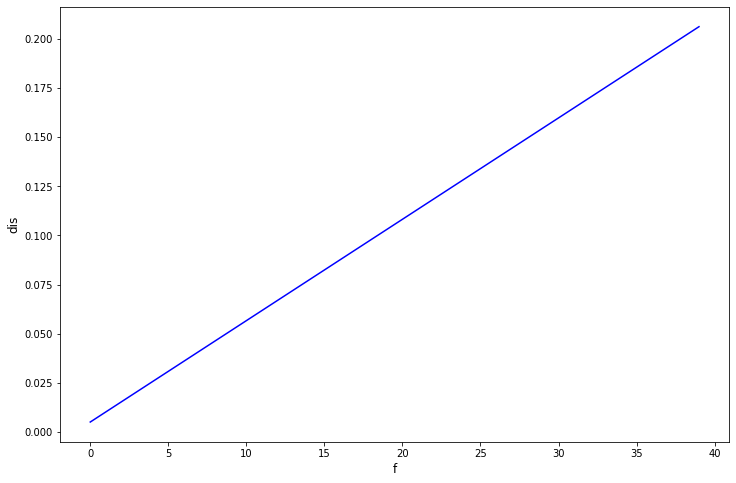

In [43]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
ax.plot(zs, label='静的荷重z方向変位001', color=(0, 0, 1))
plt.xlabel('f', fontsize=12)
plt.ylabel('dis', fontsize=12)
plt.savefig('静的荷重z方向変位001.png')
plt.show()

In [46]:
data002 = np.zeros((40, 23), dtype=np.float)
file_path = 'test002.txt'
for i in range(40):
    _, data002[i] = main_3d_forward_by_f(file_path, i+1)

time: 0.009sec
time: 0.009sec
time: 0.008sec
time: 0.008sec
time: 0.008sec
time: 0.007sec
time: 0.008sec
time: 0.008sec
time: 0.007sec
time: 0.007sec
time: 0.007sec
time: 0.006sec
time: 0.006sec
time: 0.007sec
time: 0.006sec
time: 0.007sec
time: 0.006sec
time: 0.006sec
time: 0.007sec
time: 0.006sec
time: 0.006sec
time: 0.006sec
time: 0.006sec
time: 0.006sec
time: 0.007sec
time: 0.006sec
time: 0.007sec
time: 0.006sec
time: 0.007sec
time: 0.006sec
time: 0.007sec
time: 0.006sec
time: 0.006sec
time: 0.007sec
time: 0.007sec
time: 0.007sec
time: 0.007sec
time: 0.009sec
time: 0.018sec
time: 0.008sec


In [48]:
zs002 = np.zeros(len(data002), dtype=np.float64)
for i in range(len(zs002)):
    zs002[i] = data002[i, 22]

In [51]:
for i in range(len(zs002) - 1):
    print(zs002[i+1] - zs002[i])

0.005152429203231486
0.0051524292032314855
0.005152429203231487
0.005152429203231487
0.005152429203231484
0.005152429203231487
0.005152429203231487
0.00515242920323148
0.005152429203231494
0.005152429203231487
0.00515242920323148
0.005152429203231487
0.005152429203231487
0.005152429203231487
0.005152429203231487
0.005152429203231473
0.005152429203231487
0.005152429203231501
0.005152429203231487
0.005152429203231473
0.005152429203231501
0.005152429203231473
0.005152429203231487
0.005152429203231501
0.005152429203231473
0.005152429203231501
0.005152429203231473
0.005152429203231473
0.005152429203231501
0.005152429203231501
0.005152429203231473
0.005152429203231501
0.005152429203231446
0.005152429203231501
0.005152429203231473
0.005152429203231501
0.005152429203231501
0.005152429203231473
0.005152429203231501
